<a href="https://colab.research.google.com/github/NataliaOsiecka/dw_matrix_road_signs/blob/master/day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import datetime
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.metrics import accuracy_score

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_signs'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_signs


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [45]:
model.fit(X_train, y_train)

1088/1088 [==============================] - 3s 3ms/step - loss: 7.9186 - accuracy: 0.7906


In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  Flatten(),
  Dense(num_classes, activation='softmax'),
  ])
  
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train, 
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
      )
  return model


In [47]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 9ms/step - loss: 35.6428 - accuracy: 0.7212 - val_loss: 0.2560 - val_accuracy: 0.9350
Epoch 2/5
272/272 [==============================] - 2s 9ms/step - loss: 0.2302 - accuracy: 0.9452 - val_loss: 0.1080 - val_accuracy: 0.9724
Epoch 3/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1398 - accuracy: 0.9681 - val_loss: 0.2060 - val_accuracy: 0.9578
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1254 - accuracy: 0.9713 - val_loss: 0.1143 - val_accuracy: 0.9766
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1133 - accuracy: 0.9755 - val_loss: 0.1092 - val_accuracy: 0.9725


In [48]:
y_pred_prob = model_trained.predict(X_test)
y_pred_prob

array([[3.8483780e-10, 4.4495384e-03, 1.6800356e-01, ..., 1.6209220e-03,
        8.2257457e-02, 2.9111955e-02],
       [1.9960843e-10, 9.5856795e-04, 7.7103657e-01, ..., 1.6186104e-04,
        2.1996655e-05, 2.8201955e-04],
       [1.6985340e-10, 1.1334474e-03, 1.7134693e-02, ..., 4.6974733e-03,
        5.0394740e-02, 1.9636814e-02],
       ...,
       [2.0117136e-07, 9.4459523e-05, 2.5666578e-04, ..., 1.8759265e-05,
        2.1776075e-05, 1.3607490e-08],
       [5.2005487e-07, 3.2490867e-04, 1.8605856e-03, ..., 3.4410958e-04,
        2.8452463e-04, 3.1719154e-07],
       [6.5708792e-07, 3.3660443e-04, 2.2443121e-03, ..., 6.1252475e-05,
        3.5535715e-05, 3.3423709e-07]], dtype=float32)

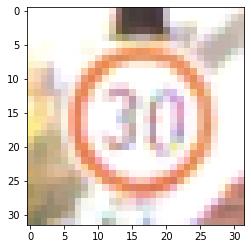

In [49]:
plt.imshow(X_test[400])

In [50]:
ls data

signnames.csv  test.p  train.p


In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [52]:
labels_dict[np.argmax(y_pred_prob[400])]

'Speed limit (70km/h)'

<BarContainer object of 43 artists>

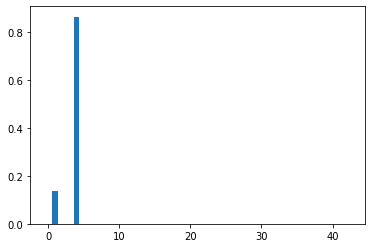

In [53]:
plt.bar(range(43), y_pred_prob[400])

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):

  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [55]:
predict(model_trained, X_test, y_test)

0.7947845804988662

In [56]:
y_test_norm = np.argmax(y_test)
y_pred_prob = model_trained.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_norm

41

In [57]:
y_test.shape

(4410, 43)

In [58]:
y_pred_prob.shape

(4410, 43)

In [59]:
y_pred.shape

(4410,)

In [60]:
y_train.shape

(34799, 43)

In [0]:
def train_and_predict(model):  
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [64]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPool2D(),
  Dropout(0.3),
  Flatten(),

  Dense(1024, activation='relu'),
  Dropout(0.3),

  Dense(num_classes, activation='softmax'),
  ])

train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 4.8998 - accuracy: 0.1623 - val_loss: 2.6891 - val_accuracy: 0.2805
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 1.7882 - accuracy: 0.4921 - val_loss: 0.7085 - val_accuracy: 0.8096
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.8032 - accuracy: 0.7622 - val_loss: 0.2481 - val_accuracy: 0.9354
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.4826 - accuracy: 0.8559 - val_loss: 0.1267 - val_accuracy: 0.9719
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3333 - accuracy: 0.8999 - val_loss: 0.0809 - val_accuracy: 0.9808


0.8852607709750567

In [66]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPool2D(),
  Dropout(0.3),
  Flatten(),

  Dense(1024, activation='relu'),
  Dropout(0.3),

  Dense(num_classes, activation='softmax'),
  ])

train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 2.4249 - accuracy: 0.4761 - val_loss: 0.3746 - val_accuracy: 0.9109
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 0.6037 - accuracy: 0.8213 - val_loss: 0.1589 - val_accuracy: 0.9638
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.3511 - accuracy: 0.8951 - val_loss: 0.0780 - val_accuracy: 0.9861
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2499 - accuracy: 0.9259 - val_loss: 0.0447 - val_accuracy: 0.9911
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1758 - accuracy: 0.9495 - val_loss: 0.0253 - val_accuracy: 0.9936


0.9675736961451247

In [67]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Flatten(),

  Dense(1024, activation='relu'),
  Dropout(0.3),

  Dense(num_classes, activation='softmax'),
  ])

train_and_predict(get_cnn_v4(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.7185 - accuracy: 0.2953 - val_loss: 0.9952 - val_accuracy: 0.7217
Epoch 2/5
272/272 [==============================] - 3s 13ms/step - loss: 0.9609 - accuracy: 0.7020 - val_loss: 0.3417 - val_accuracy: 0.9029
Epoch 3/5
272/272 [==============================] - 3s 13ms/step - loss: 0.4947 - accuracy: 0.8451 - val_loss: 0.1576 - val_accuracy: 0.9603
Epoch 4/5
272/272 [==============================] - 3s 13ms/step - loss: 0.3345 - accuracy: 0.8944 - val_loss: 0.0779 - val_accuracy: 0.9767
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2559 - accuracy: 0.9232 - val_loss: 0.0437 - val_accuracy: 0.9881


0.9562358276643991

In [68]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Flatten(),

  Dense(1024, activation='relu'),
  Dropout(0.3),

  Dense(1024, activation='relu'),
  Dropout(0.3),

  Dense(num_classes, activation='softmax'),
  ])

train_and_predict(get_cnn_v5(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.6609 - accuracy: 0.2714 - val_loss: 1.1139 - val_accuracy: 0.6486
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 0.9097 - accuracy: 0.7155 - val_loss: 0.2061 - val_accuracy: 0.9444
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.4059 - accuracy: 0.8767 - val_loss: 0.0941 - val_accuracy: 0.9781
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2636 - accuracy: 0.9214 - val_loss: 0.0491 - val_accuracy: 0.9853
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2026 - accuracy: 0.9405 - val_loss: 0.0347 - val_accuracy: 0.9900


0.9600907029478458

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [72]:
model = get_cnn_v5((32,32,1), num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.6995 - accuracy: 0.2441 - val_loss: 0.7239 - val_accuracy: 0.7574
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 0.5195 - accuracy: 0.8289 - val_loss: 0.1040 - val_accuracy: 0.9699
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.2088 - accuracy: 0.9331 - val_loss: 0.0468 - val_accuracy: 0.9861
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1366 - accuracy: 0.9567 - val_loss: 0.0344 - val_accuracy: 0.9903
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1065 - accuracy: 0.9672 - val_loss: 0.0199 - val_accuracy: 0.9939


0.9668934240362812

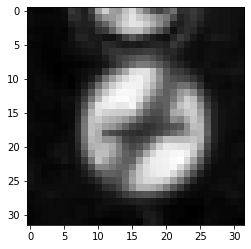

In [74]:
plt.imshow(color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray'))

In [0]:
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:,:,2] = exposure.equaize_adathist(hsv[:,:,2])
  img = color.hsv2rgb(hsv)

  return img